In [2]:
import os

# Chặn Transformers tự động import TensorFlow/Flax (tránh lỗi protobuf / MessageFactory)
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


print("[OK] Environment flags set (no TF / no Flax).")

[OK] Environment flags set (no TF / no Flax).


In [3]:
import sys, torch
import numpy as np

import transformers, datasets, accelerate

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Accelerate:", accelerate.__version__)

Python: 3.12.12
Torch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4
Transformers: 4.57.1
Datasets: 4.4.1
Accelerate: 1.11.0


In [4]:
import importlib.util, subprocess

def pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# sacrebleu: bắt buộc
if importlib.util.find_spec("sacrebleu") is None:
    print("[INFO] Installing sacrebleu ...")
    pip_install("sacrebleu")
else:
    print("[OK] sacrebleu already installed")

# hf_transfer: optional tăng tốc push/pull
if importlib.util.find_spec("hf_transfer") is None:
    print("[INFO] Installing hf_transfer (optional) ...")
    pip_install("hf_transfer")
else:
    print("[OK] hf_transfer already installed")

[INFO] Installing sacrebleu ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.7 MB/s eta 0:00:00
[OK] hf_transfer already installed


In [5]:
import re, math, random, hashlib
from pathlib import Path
from typing import List, Dict, Any

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import sacrebleu

print("[OK] Imports done.")

E0000 00:00:1765938621.377048      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765938621.489803      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765938622.514332      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765938622.514371      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765938622.514374      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765938622.514376      55 computation_placer.cc:177] computation placer already registered. Please check linka

[OK] Imports done.


In [6]:
from pathlib import Path

def find_dataset_dir() -> Path:
    base = Path("/kaggle/input")
    for d in base.glob("*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    for d in base.glob("*/*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    raise FileNotFoundError("Could not find dataset folder containing train.en.txt/train.vi.txt")

DATA_DIR = find_dataset_dir()
print("[OK] Found dataset dir:", DATA_DIR)

TRAIN_EN = DATA_DIR / "train.en.txt"
TRAIN_VI = DATA_DIR / "train.vi.txt"
TEST_EN  = DATA_DIR / "public_test.en.txt"
TEST_VI  = DATA_DIR / "public_test.vi.txt"

for p in [TRAIN_EN, TRAIN_VI, TEST_EN, TEST_VI]:
    print("[CHECK]", p.name, "->", "OK" if p.exists() else "NOT FOUND")

[OK] Found dataset dir: /kaggle/input/databaitoanphu
[CHECK] train.en.txt -> OK
[CHECK] train.vi.txt -> OK
[CHECK] public_test.en.txt -> OK
[CHECK] public_test.vi.txt -> OK


In [12]:
SRC_LANG = "vi_VN"
TGT_LANG = "en_XX"
def read_lines(path: Path, encoding="utf-8"):
    with open(path, "r", encoding=encoding, errors="replace") as f:
        return [line.rstrip("\n") for line in f]

def load_parallel(en_path: Path, vi_path: Path, name="data"):
    en_lines = read_lines(en_path)
    vi_lines = read_lines(vi_path)
    n = min(len(en_lines), len(vi_lines))
    if len(en_lines) != len(vi_lines):
        print(f"[WARN] {name} mismatch -> EN={len(en_lines):,}, VI={len(vi_lines):,}. Using first {n:,} pairs.")
    else:
        print(f"[INFO] {name} lines -> {n:,} pairs.")
    return list(zip(vi_lines[:n], en_lines[:n]))

train_pairs_raw = load_parallel(TRAIN_EN, TRAIN_VI, "train_raw")
test_pairs_raw  = load_parallel(TEST_EN,  TEST_VI,  "test_raw")

print("[SAMPLE train_raw]", train_pairs_raw[0])
print("[SAMPLE test_raw ]", test_pairs_raw[0])

[INFO] train_raw lines -> 500,000 pairs.
[INFO] test_raw lines -> 3,000 pairs.
[SAMPLE train_raw] ('Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital')
[SAMPLE test_raw ] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')


In [8]:
import re, hashlib

def basic_clean(s: str) -> str:
    s = "" if s is None else s
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

MIN_CHARS = 2
MAX_CHARS = 400

def is_good_pair(src: str, tgt: str) -> bool:
    if not src or not tgt:
        return False
    if len(src) < MIN_CHARS or len(tgt) < MIN_CHARS:
        return False
    if len(src) > MAX_CHARS or len(tgt) > MAX_CHARS:
        return False
    return True

def clean_filter_dedup(pairs, name="data"):
    # clean + filter
    cleaned = []
    for src, tgt in pairs:
        src = basic_clean(src)
        tgt = basic_clean(tgt)
        if is_good_pair(src, tgt):
            cleaned.append((src, tgt))
    print(f"[INFO] {name}: after clean+filter -> {len(cleaned):,} pairs")

    # dedup
    seen = set()
    dedup = []
    for src, tgt in cleaned:
        h = hashlib.md5((src + "\t" + tgt).encode("utf-8")).hexdigest()
        if h not in seen:
            seen.add(h)
            dedup.append((src, tgt))
    print(f"[INFO] {name}: after dedup       -> {len(dedup):,} pairs")
    return dedup

train_pairs = clean_filter_dedup(train_pairs_raw, "train")
test_pairs  = clean_filter_dedup(test_pairs_raw,  "test")

print("[SAMPLE clean train]", train_pairs[0])
print("[SAMPLE clean test ]", test_pairs[0])

[INFO] train: after clean+filter -> 489,008 pairs
[INFO] train: after dedup       -> 340,522 pairs
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[SAMPLE clean train] ('Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital')
[SAMPLE clean test ] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')


In [ ]:
import random
from datasets import Dataset, DatasetDict

SEED = 42
N_TOTAL = 10000

TRAIN_RATIO = 0.9  # 90/10

# 1) shuffle train_pairs
rng = random.Random(SEED)
rng.shuffle(train_pairs)

# 2) lấy 5000 (nếu không đủ thì lấy hết)
n_take = min(N_TOTAL, len(train_pairs))
subset = train_pairs[:n_take]
print(f"[INFO] Train pairs available: {len(train_pairs):,}")
print(f"[INFO] Taking from train     : {n_take:,} pairs")

# 3) split 90/10
n_train = int(n_take * TRAIN_RATIO)
n_val = n_take - n_train

train_subset = subset[:n_train]
val_subset   = subset[n_train:]

print(f"[INFO] Split -> train={len(train_subset):,} | val={len(val_subset):,}")

# 4) build datasets
train_ds = Dataset.from_dict({
    "src_text": [s for s, _ in train_subset],
    "tgt_text": [t for _, t in train_subset],
})
val_ds = Dataset.from_dict({
    "src_text": [s for s, _ in val_subset],
    "tgt_text": [t for _, t in val_subset],
})

# test giữ nguyên từ public_test
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

ds = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
print(ds)

print("[SAMPLE TRAIN]", ds["train"][0])
print("[SAMPLE VAL  ]", ds["validation"][0])
print("[SAMPLE TEST ]", ds["test"][0])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MODEL_ID = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "vi_VN"
TGT_LANG = "en_XX"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

# set src/tgt language (QUAN TRỌNG)
tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG   # <-- FIX KeyError: None

forced_bos_token_id = tokenizer.lang_code_to_id[TGT_LANG]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[OK] tokenizer/model loaded")
print("[INFO] tokenizer.src_lang:", tokenizer.src_lang)
print("[INFO] tokenizer.tgt_lang:", tokenizer.tgt_lang)
print("[INFO] forced_bos_token_id:", forced_bos_token_id)

In [ ]:
# đảm bảo ds đã có ở cell split 5000 (train/validation/test)
assert "ds" in globals(), "You must run the data-loading/splitting cell to create `ds` first!"
assert "tokenizer" in globals(), "You must run the tokenizer/model loading cell first!"

MAX_SRC_LEN = 256
MAX_TGT_LEN = 256

def preprocess_batch(batch):
    tokenizer.src_lang = SRC_LANG

    model_inputs = tokenizer(
        batch["src_text"],
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=False,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["tgt_text"],
            max_length=MAX_TGT_LEN,
            truncation=True,
            padding=False,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = ds["train"].map(preprocess_batch, batched=True, remove_columns=ds["train"].column_names)
val_tok   = ds["validation"].map(preprocess_batch, batched=True, remove_columns=ds["validation"].column_names)
test_tok  = ds["test"].map(preprocess_batch, batched=True, remove_columns=ds["test"].column_names)

print("[OK] Tokenized sizes:",
      "train", len(train_tok),
      "| val", len(val_tok),
      "| test", len(test_tok))

In [ ]:
#Bleu trước khi train
def bleu_on_test(max_samples=None):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    hyps = []
    bs = 16 if torch.cuda.is_available() else 4
    for i in range(0, len(srcs), bs):
        hyps.extend(translate_vi2en(srcs[i:i+bs]))

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    print(f"[TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    return bleu
# _ = bleu_on_test(max_samples=200) 

In [9]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()

# tên secret của anh là HF_TOKEN (đúng như panel)
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)
print("[OK] Logged in to Hugging Face.")

[OK] Logged in to Hugging Face.


In [ ]:
import os, inspect
import torch
import pandas as pd
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

# ====== CHECK ======
assert "model" in globals(), "Missing `model`"
assert "tokenizer" in globals(), "Missing `tokenizer`"
assert "train_tok" in globals(), "Missing `train_tok`"
assert "val_tok" in globals(), "Missing `val_tok`"
assert "SRC_LANG" in globals() and "TGT_LANG" in globals(), "Missing SRC_LANG/TGT_LANG"

tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG

OUTPUT_DIR  = "mbart50_vien"
NUM_EPOCHS  = 7

TRAIN_BS = 2
EVAL_BS  = 2
GRAD_ACC = 8
LR       = 1e-5

HF_REPO_ID = "ngothuyet/mbart50-vien"
HF_PRIVATE = True

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

ta_kwargs = dict(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LR,
    warmup_ratio=0.03,
    weight_decay=0.01,

    predict_with_generate=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none",
    
    # ✅ SAVE BEST theo VAL LOSS (eval_loss)
    save_strategy="epoch",        # cần save để chọn best
    save_only_model=True,         # tránh lỗi optimizer.pt
    save_total_limit=1,           # chỉ giữ 1 cái tốt nhất

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

sig = inspect.signature(Seq2SeqTrainingArguments.__init__).parameters

if "logging_strategy" in sig:
    ta_kwargs["logging_strategy"] = "epoch"

if "evaluation_strategy" in sig:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig:
    ta_kwargs["eval_strategy"] = "epoch"
else:
    raise ValueError("Transformers version: missing evaluation_strategy/eval_strategy")

ta_kwargs.update(dict(
    push_to_hub=True,
    hub_model_id=HF_REPO_ID,
    hub_private_repo=HF_PRIVATE,
    hub_strategy="end",           # chỉ push cuối
))

training_args = Seq2SeqTrainingArguments(**ta_kwargs)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
)

print("[INFO] Start training...")
train_result = trainer.train()
print("\n===== TRAIN DONE =====")
print(train_result)

print("\n===== BEST (by eval_loss) =====")
print("best_model_checkpoint:", trainer.state.best_model_checkpoint)
print("best_metric(eval_loss):", trainer.state.best_metric)

print("\n===== FINAL EVAL (VAL) on BEST =====")
final_metrics = trainer.evaluate()
for k, v in final_metrics.items():
    print(f"{k}: {v}")

# Lưu BEST local (trainer.model đã là best vì load_best_model_at_end=True)
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("[OK] Saved BEST model/tokenizer to:", OUTPUT_DIR)

# TSV train/val loss như cũ
logs = trainer.state.log_history
train_loss_by_epoch = {}
val_loss_by_epoch = {}

for row in logs:
    if "epoch" in row and "loss" in row and "eval_loss" not in row:
        train_loss_by_epoch[row["epoch"]] = row["loss"]
    if "epoch" in row and "eval_loss" in row:
        val_loss_by_epoch[row["epoch"]] = row["eval_loss"]

epochs = sorted(set(list(train_loss_by_epoch.keys()) + list(val_loss_by_epoch.keys())))
df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": [train_loss_by_epoch.get(e, None) for e in epochs],
    "val_loss": [val_loss_by_epoch.get(e, None) for e in epochs],
})

tsv_path = os.path.join(OUTPUT_DIR, "train_val_loss.tsv")
df.to_csv(tsv_path, sep="\t", index=False)
print("[OK] Saved TSV:", tsv_path)
display(df)

# ✅ Push BEST + TSV (không còn push “bản cuối” theo nghĩa last-epoch)
trainer.push_to_hub(commit_message=f"Push BEST by eval_loss={trainer.state.best_metric} + train_val_loss.tsv")
print("[OK] Pushed BEST model + TSV to Hugging Face.")


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

HF_REPO = "ngothuyet/mbart50-vien"

tokenizer = AutoTokenizer.from_pretrained(HF_REPO, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(HF_REPO)

tokenizer.src_lang = "vi_VN"
tokenizer.tgt_lang = "en_XX"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[OK] Loaded model from HF:", HF_REPO)

tokenizer_config.json:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

[OK] Loaded model from HF: ngothuyet/mbart50-vien


In [13]:
# @torch.inference_mode()
# def translate_en2vi(texts, num_beams=5, length_penalty=1.0, no_repeat_ngram_size=3, max_new_tokens=128):
#     model.eval()
#     tokenizer.src_lang = SRC_LANG
#     enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SRC_LEN).to(model.device)
#     out = model.generate(
#         **enc,
#         forced_bos_token_id=tokenizer.lang_code_to_id[TGT_LANG],
#         num_beams=num_beams,
#         length_penalty=length_penalty,
#         no_repeat_ngram_size=no_repeat_ngram_size,
#         max_new_tokens=max_new_tokens,
#         early_stopping=True
#     )
#     return tokenizer.batch_decode(out, skip_special_tokens=True)

import torch
from typing import List

MAX_SRC_LEN = 256

@torch.inference_mode()
def translate_vi2en(
    texts: List[str],
    num_beams: int = 5,
    length_penalty: float = 1.0,
    no_repeat_ngram_size: int = 3,
    max_new_tokens: int = 128,
):
    model.eval()
    tokenizer.src_lang = SRC_LANG
    tokenizer.tgt_lang = TGT_LANG

    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SRC_LEN
    ).to(model.device)

    generated = model.generate(
        **enc,
        forced_bos_token_id=tokenizer.lang_code_to_id[TGT_LANG],
        num_beams=num_beams,
        length_penalty=length_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size,
        max_new_tokens=max_new_tokens,
        early_stopping=True,
    )

    return tokenizer.batch_decode(generated, skip_special_tokens=True)

# Demo nhanh
demo = [
    "Tôi muốn đi ngủ vì tôi bị đau mắt"
]
print("[INPUT ]", demo)
print("[OUTPUT]", translate_vi2en(demo, num_beams=5, length_penalty=1.0, no_repeat_ngram_size=3))





[INPUT ] ['Tôi muốn đi ngủ vì tôi bị đau mắt']
[OUTPUT] ['I want to go to bed because I have opacities.']


[OK] Downloaded: /root/.cache/huggingface/hub/models--ngothuyet--mbart50-vien/snapshots/bdd395c83a113df18528f09f3b56210fa38b7664/train_val_loss.tsv


,epoch,train_loss,val_loss
0,1.0,1.7502,1.636605
1,2.0,1.4753,1.587630
2,3.0,1.3303,1.558410
3,4.0,1.2384,1.555562
4,5.0,1.1640,1.556075
5,6.0,1.1120,1.555562


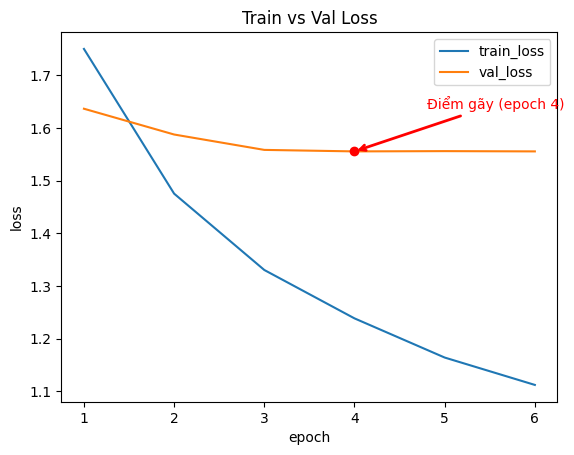

In [18]:
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt

REPO_ID  = "ngothuyet/mbart50-vien"
FILENAME = "train_val_loss.tsv"

# tải file về kaggle
local_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
print("[OK] Downloaded:", local_path)

# đọc TSV
df = pd.read_csv(local_path, sep="\t")
display(df.head(10))

# lấy điểm gãy epoch 4
knee_epoch = 4
row = df.loc[df["epoch"] == knee_epoch].iloc[0]
xk, yk = float(row["epoch"]), float(row["val_loss"])

# ===== VẼ BIỂU ĐỒ =====
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")

# đánh dấu điểm gãy
plt.scatter([xk], [yk], color="red", zorder=5)
plt.annotate(
    "Điểm gãy (epoch 4)",
    xy=(xk, yk),
    xytext=(xk + 0.8, yk + 0.08),
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    color="red"
)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.show()


In [20]:
from datasets import Dataset

# đọc song song public_test.en/vi -> list[(en, vi)]
test_pairs_raw = load_parallel(TEST_EN, TEST_VI, "test_raw")

# clean/filter/dedup giống pipeline train
test_pairs = clean_filter_dedup(test_pairs_raw, "test")

print(f"[INFO] public_test after clean: {len(test_pairs):,} pairs")
print("[SAMPLE TEST]", test_pairs[0])

# tạo ds_test (giữ nguyên ds train/val của anh nếu đã có)
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

# gắn vào DatasetDict nếu đã có ds, còn không thì tạo ds mới
if "ds" in globals():
    ds["test"] = test_ds
else:
    from datasets import DatasetDict
    ds = DatasetDict({"test": test_ds})

print("[OK] ds['test'] size:", len(ds["test"]))

[INFO] test_raw lines -> 3,000 pairs.
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[INFO] public_test after clean: 2,943 pairs
[SAMPLE TEST] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')
[OK] ds['test'] size: 2943


In [26]:
import os, json, time
import torch
import sacrebleu
from tqdm.auto import tqdm


OUTPUT_DIR  = "mbart50_vien"
def bleu_on_public_test_and_push(batch_size=16):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    bs = batch_size if torch.cuda.is_available() else max(2, batch_size // 4)

    hyps = []
    t0 = time.time()

    for i in tqdm(range(0, len(srcs), bs), desc="BLEU on public_test", total=(len(srcs) + bs - 1)//bs):
        batch = srcs[i:i+bs]
        hyps.extend(
            translate_vi2en(
                batch,
                num_beams=5,
                length_penalty=1.0,
                no_repeat_ngram_size=3,
                max_new_tokens=128
            )
        )

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    elapsed = time.time() - t0

    metrics = {
        "public_test_sacrebleu": float(bleu),
        "public_test_size": int(len(srcs)),
        "batch_size": int(bs),
        "elapsed_sec": float(elapsed),
    }

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    json_path = os.path.join(OUTPUT_DIR, "public_test_metrics.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    txt_path = os.path.join(OUTPUT_DIR, "public_test_bleu.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"public_test_sacrebleu\t{bleu:.4f}\n")

    print(f"\n[PUBLIC_TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    print("[OK] Saved:", json_path)
    print("[OK] Saved:", txt_path)

    # push lên repo model
    trainer.push_to_hub(commit_message=f"Add public_test sacreBLEU={bleu:.2f}")
    print("[OK] Pushed public_test BLEU files to Hugging Face.")

    return bleu, metrics

_ = bleu_on_public_test_and_push(batch_size=16)

BLEU on public_test:   0%|          | 0/184 [00:00<?, ?it/s]


[PUBLIC_TEST] sacreBLEU (2943 samples): 29.39
[OK] Saved: mbart50_vien/public_test_metrics.json
[OK] Saved: mbart50_vien/public_test_bleu.txt


NameError: name 'trainer' is not defined

In [34]:
import re
from collections import Counter
import pandas as pd

# =========================
# Helpers
# =========================
_num_pat = re.compile(r"\d+(?:[.,:/-]\d+)*")
_word_pat = re.compile(r"[A-Za-zÀ-ỹ]+(?:'[A-Za-zÀ-ỹ]+)?|\d+(?:[.,:/-]\d+)*", re.UNICODE)

def _tokenize(s: str):
    return _word_pat.findall((s or "").strip())

def _extract_numbers(s: str):
    return set(_num_pat.findall((s or "")))

def _extract_capitalized_words(s: str):
    # tên riêng đơn giản: token bắt đầu bằng chữ hoa
    toks = _tokenize(s)
    out = set()
    for t in toks:
        if len(t) >= 2 and t[0].isupper() and any(c.isalpha() for c in t):
            out.add(t)
    return out

def _ngram_counts(tokens, n=3):
    if len(tokens) < n:
        return Counter()
    return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

def _has_repetition(tokens):
    # lặp n-gram: bigram lặp >=3 hoặc trigram lặp >=2
    c2 = _ngram_counts(tokens, n=2)
    c3 = _ngram_counts(tokens, n=3)
    rep2 = (len(c2) > 0) and (max(c2.values()) >= 3)
    rep3 = (len(c3) > 0) and (max(c3.values()) >= 2)
    return rep2 or rep3

def _untranslated_vi_chars(text: str):
    # nếu output EN mà vẫn có nhiều ký tự tiếng Việt
    vi_chars = set("ăâđêôơưáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệ"
                   "íìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ")
    t = (text or "").lower()
    return sum(1 for ch in t if ch in vi_chars)

def _jaccard(a, b):
    a, b = set(a), set(b)
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

# =========================
# Core tagger (rule-based)
# =========================
def tag_mt_errors(
    src: str, ref: str, hyp: str,
    direction="vi-en",
    omission_ratio=0.75,
    addition_ratio=1.35,
    overlap_literal_thr=0.55,
):
    src = src or ""
    ref = ref or ""
    hyp = hyp or ""

    src_toks = _tokenize(src.lower())
    ref_toks = _tokenize(ref.lower())
    hyp_toks = _tokenize(hyp.lower())

    len_ref = max(1, len(ref_toks))
    len_hyp = len(hyp_toks)
    len_ratio = len_hyp / len_ref

    nums_ref = _extract_numbers(ref)
    nums_hyp = _extract_numbers(hyp)

    caps_ref = _extract_capitalized_words(ref)
    caps_hyp = _extract_capitalized_words(hyp)

    overlap_ref_hyp = _jaccard(ref_toks, hyp_toks)
    overlap_src_hyp = _jaccard(src_toks, hyp_toks)

    tags = []

    # Omission / Addition (length)
    if len_ratio < omission_ratio:
        tags.append("Omission_length")
    if len_ratio > addition_ratio:
        tags.append("Addition_length")

    # Numbers / Named Entities mismatch
    if (nums_ref - nums_hyp):
        tags.append("Number_mismatch_omit")
    if (nums_hyp - nums_ref):
        tags.append("Number_mismatch_add")

    if (caps_ref - caps_hyp):
        tags.append("NE_mismatch_omit")
    if (caps_hyp - caps_ref):
        tags.append("NE_mismatch_add")

    # Repetition
    if _has_repetition(hyp_toks):
        tags.append("Repetition")

    # Untranslated / Literal suspects
    if direction == "vi-en":
        if _untranslated_vi_chars(hyp) >= 3:
            tags.append("Untranslated")
        if overlap_src_hyp >= overlap_literal_thr:
            tags.append("Literal_translation_suspect")
    else:  # en-vi
        en_like = sum(1 for ch in hyp if ('A' <= ch <= 'Z') or ('a' <= ch <= 'z'))
        if en_like >= 12 and len(hyp) >= 25:
            tags.append("Untranslated")
        if overlap_src_hyp >= overlap_literal_thr:
            tags.append("Literal_translation_suspect")

    # Punctuation/style (tham chiếu có .?! nhưng hyp không có)
    if ref.strip() and hyp.strip():
        if (ref.strip()[-1] in ".?!") and (hyp.strip()[-1] not in ".?!"):
            tags.append("Punctuation_style")

    # Terminology miss (heuristic): token dài (>=12) có trong ref nhưng mất trong hyp
    long_ref = {t for t in ref_toks if len(t) >= 12}
    if (long_ref - set(hyp_toks)):
        tags.append("Terminology_miss_suspect")

    # Semantic suspect (proxy): không rõ omission/addition nhưng overlap ref-hyp rất thấp
    if ("Omission_length" not in tags) and ("Addition_length" not in tags):
        if (overlap_ref_hyp < 0.25) and (len_ref >= 6):
            tags.append("Semantic_mismatch_suspect")

    info = {
        "len_ratio(hyp/ref)": round(len_ratio, 3),
        "overlap_ref_hyp": round(overlap_ref_hyp, 3),
        "overlap_src_hyp": round(overlap_src_hyp, 3),
        "nums_ref_missing_in_hyp": sorted(nums_ref - nums_hyp),
        "nums_hyp_extra_vs_ref": sorted(nums_hyp - nums_ref),
        "NE_ref_missing_in_hyp": sorted(caps_ref - caps_hyp),
        "NE_hyp_extra_vs_ref": sorted(caps_hyp - caps_ref),
        "error_tags": ", ".join(tags),
    }
    return tags, info

# =========================
# End-to-end: run on your ds["test"]
# =========================
def run_error_analysis_on_ds(
    ds,
    split="test",
    translate_fn=None,         # ví dụ: translate_vi2en
    direction="vi-en",
    batch_size=16,
    max_samples=None,
):
    assert translate_fn is not None, "Anh truyền translate_fn vào (ví dụ translate_vi2en)."

    srcs = ds[split]["src_text"]
    refs = ds[split]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    # 1) generate hyps theo batch (giống code BLEU của anh)
    hyps = []
    for i in range(0, len(srcs), batch_size):
        hyps.extend(translate_fn(srcs[i:i+batch_size]))

    # 2) tag lỗi
    rows = []
    counts = Counter()

    for i, (src, ref, hyp) in enumerate(zip(srcs, refs, hyps)):
        tags, info = tag_mt_errors(src, ref, hyp, direction=direction)
        for t in tags:
            counts[t] += 1

        rows.append({
            "id": i,
            "src": src,
            "ref": ref,
            "hyp": hyp,
            **info
        })

    df_err = pd.DataFrame(rows)
    summary = pd.DataFrame(
        [{"error_type": k, "count": v, "rate": v/len(df_err)} for k, v in counts.most_common()]
    )

    return df_err, summary


In [35]:
df_err, summary = run_error_analysis_on_ds(
    ds=ds,
    split="test",
    translate_fn=translate_vi2en,
    direction="vi-en",
    batch_size=16,
    max_samples=200  # bỏ dòng này nếu muốn chạy full
)

display(summary)
display(df_err[df_err["error_tags"] != ""].head(20))


,error_type,count,rate
0,NE_mismatch_omit,133,0.665
1,NE_mismatch_add,126,0.630
2,Terminology_miss_suspect,78,0.390
3,Number_mismatch_omit,24,0.120
4,Number_mismatch_add,23,0.115
5,Addition_length,18,0.090
6,Omission_length,15,0.075
7,Semantic_mismatch_suspect,13,0.065
8,Repetition,5,0.025


,id,src,ref,hyp,len_ratio(hyp/ref),overlap_ref_hyp,overlap_src_hyp,nums_ref_missing_in_hyp,nums_hyp_extra_vs_ref,NE_ref_missing_in_hyp,NE_hyp_extra_vs_ref,error_tags
0,0,Thực trạng kiến thức và thực hành của người có...,"Knowledge, practices in public health service ...",Current knowledge and practice of health insur...,1.632,0.355,0.031,[],[2017],"[Knowledge, Vientiane]","[Chăn, Current, Vinh]","Addition_length, Number_mismatch_add, NE_misma..."
1,1,"Mô tả thực trạng kiến thức, thực hành của ngườ...","Describe knowledge, practices in public health...",To describe the knowledge and practice of heal...,1.714,0.297,0.013,[],[],"[Describe, PDR, Vientiane]","[Can, Democratic, Jan, People's, Republic, To]","Addition_length, NE_mismatch_omit, NE_mismatch..."
2,2,Phương pháp: Thiết kế nghiên mô tả cắt ngang đ...,Methodology: A cross sectional study was used ...,Methods: A cross-sectional descriptive study w...,1.174,0.471,0.109,[],[2],"[Methodology, Vientiane]","[Chan, Methods, Yench]","Number_mismatch_add, NE_mismatch_omit, NE_mism..."
3,3,Kết quả: Tỷ lệ người biết được khám chữa bệnh ...,Results: Percentage of card's holders who knew...,Results: The proportion of people who received...,0.893,0.297,0.000,[],[],[Percentage],[The],"NE_mismatch_omit, NE_mismatch_add"
4,4,Tỷ lệ người có thẻ BHYT thực hành khám chữa bệ...,Percentage of card's holders who went to the f...,The proportion of people with medical records ...,1.400,0.107,0.000,[],[],[Percentage],[The],"Addition_length, NE_mismatch_omit, NE_mismatch..."
5,5,Tỷ lệ người có thẻ BHYT sử dụng thẻ để lấy thu...,Percentage of card's holders who went to publi...,The proportion of people with a pharmacopoeia ...,0.950,0.267,0.000,[],[],[Percentage],[The],"NE_mismatch_omit, NE_mismatch_add"
6,6,"Các yếu tố khoảng cách từ nhà đến cơ sở y tế, ...",The determinants of knowledge and practices in...,Factors such as distance from home to medical ...,1.061,0.182,0.000,[],[],[The],[Factors],"NE_mismatch_omit, NE_mismatch_add, Terminology..."
7,7,Kết luận: Kiến thức và thực hành của người có ...,Conclusions: Knowledge and practices in public...,Conclusion: Knowledge and practice of people w...,1.235,0.200,0.020,[],[],[Conclusions],"[BHYT, Conclusion, Democratic, Lao, People's, ...","NE_mismatch_omit, NE_mismatch_add, Semantic_mi..."
8,8,Cần tập trung vào truyền thông cho những nhóm ...,It's necessary to provide health insurance com...,Media should be focused on groups of people li...,1.190,0.132,0.000,[],[],[It's],[Media],"NE_mismatch_omit, NE_mismatch_add, Terminology..."
9,9,Nghiên cứu xác định thuốc diclofenac natri lẫn...,Studying the method of quantification of diclo...,Study on the determination of diclofenac natri...,1.043,0.419,0.036,[],[],[Studying],[Study],"NE_mismatch_omit, NE_mismatch_add, Terminology..."


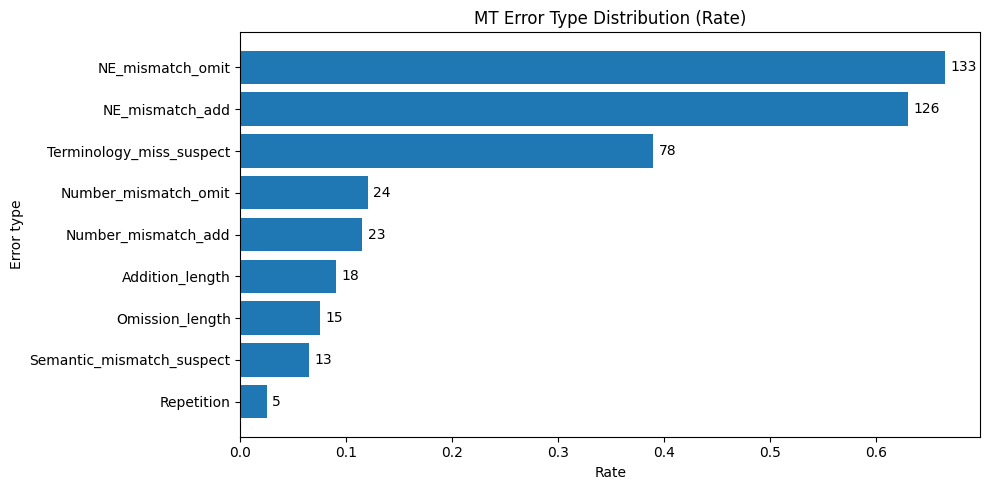

In [36]:
import matplotlib.pyplot as plt

# summary: DataFrame có các cột ["error_type","count","rate"]
# nếu summary của anh đang tên khác thì đổi lại biến

dfp = summary.sort_values("rate", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(dfp["error_type"], dfp["rate"])
plt.xlabel("Rate")
plt.ylabel("Error type")
plt.title("MT Error Type Distribution (Rate)")

# ghi count lên mỗi cột
for i, (rate, cnt) in enumerate(zip(dfp["rate"], dfp["count"])):
    plt.text(rate + 0.005, i, f"{cnt}", va="center")  # +0.005 để chữ không đè lên cột

plt.tight_layout()
plt.show()
